# 패션 MNIST 데이터 불러오기

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = \
  keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled,
                                                                      train_target, test_size=0.2,
                                                                      random_state=42)                                                                     

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
train_scaled.shape

(48000, 28, 28, 1)

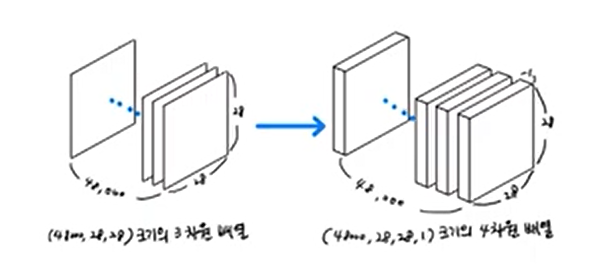

- 3차원 배열이 4차원 배열로 늘어남

# 합성곱 신경망 만들기

In [3]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same',input_shape=(28,28,1)))

In [4]:
model.add(keras.layers.MaxPooling2D(2))

- (14, 14, 32)사이즈를 가짐

In [5]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu',
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

- (7, 7, 64)사이즈를 가짐

In [6]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

- $3 \times 3 \times 1 \times 32 + 32 = 320$

- Flatten 클래승에서 (7, 7, 664) 크기의 특성 맵을 1차원 배열로 펼치면 (3136,)크기의 배열이 됨

- $3,136 \times 100 + 100 = 313,700$

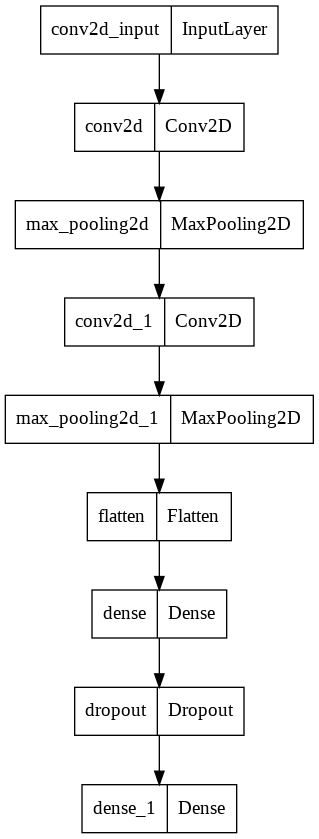

In [8]:
keras.utils.plot_model(model)

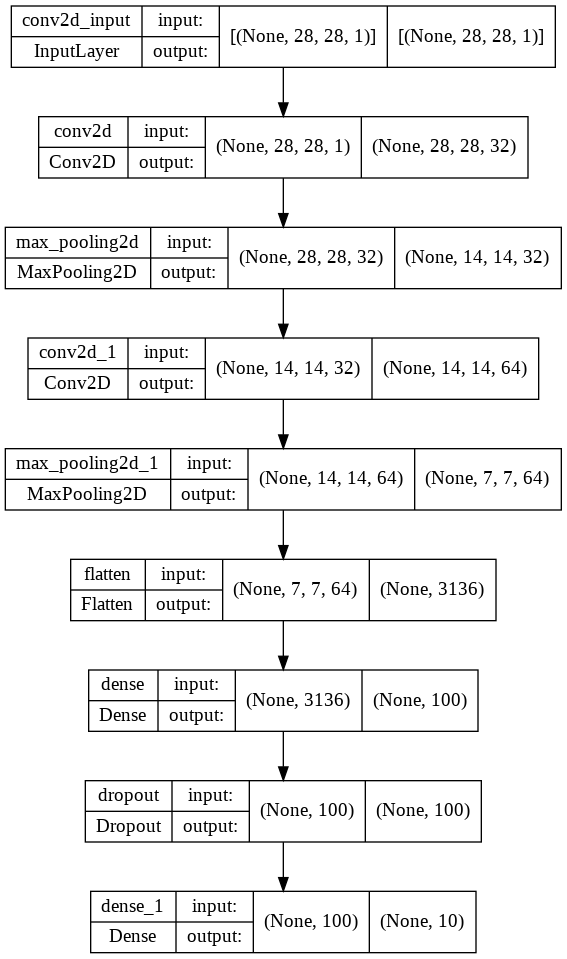

In [9]:
keras.utils.plot_model(model, show_shapes=True)

# 모델 컴파일과 훈련

In [10]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history =  model.fit(train_scaled, train_target, epochs=20,
                     validation_data=(val_scaled, val_target),
                     callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 63s 41ms/step - loss: 0.5114 - accuracy: 0.8206 - val_loss: 0.3062 - val_accuracy: 0.8881
Epoch 2/20
1500/1500 [==============================] - 58s 39ms/step - loss: 0.3359 - accuracy: 0.8795 - val_loss: 0.2665 - val_accuracy: 0.9001
Epoch 3/20
1500/1500 [==============================] - 57s 38ms/step - loss: 0.2894 - accuracy: 0.8946 - val_loss: 0.2472 - val_accuracy: 0.9089
Epoch 4/20
1500/1500 [==============================] - 57s 38ms/step - loss: 0.2571 - accuracy: 0.9057 - val_loss: 0.2418 - val_accuracy: 0.9114
Epoch 5/20
1500/1500 [==============================] - 57s 38ms/step - loss: 0.2351 - accuracy: 0.9141 - val_loss: 0.2387 - val_accuracy: 0.9109
Epoch 6/20
1500/1500 [==============================] - 59s 39ms/step - loss: 0.2128 - accuracy: 0.9200 - val_loss: 0.2190 - val_accuracy: 0.9197
Epoch 7/20
1500/1500 [==============================] - 57s 38ms/step - loss: 0.1971 - accuracy: 0.9267 - val_loss: 0.2216 -

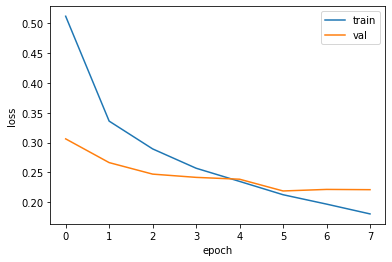

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

- EarlyStopping 클래스에서 restore_best_weights=True로 지정했으므로 현재 model 객체가 최적의 모델 파라미터로 복원되어 있음

In [12]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 4s 10ms/step - loss: 0.2190 - accuracy: 0.9197


[0.21904949843883514, 0.9197499752044678]

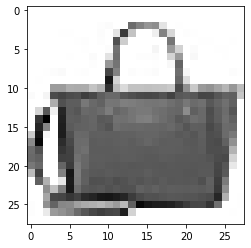

In [13]:
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [14]:
preds = model.predict(val_scaled[0:1])
print(preds)

[[1.80197345e-15 2.36095643e-21 1.84878728e-20 3.05111628e-18
  6.35279260e-18 4.08055615e-14 1.08703894e-16 3.51457740e-16
  1.00000000e+00 3.31882777e-15]]


- 아홉 번째 값이 1이고 다른 값은 0에 가까움
- 아래 그래프를 보면 자세히 볼 수 있음

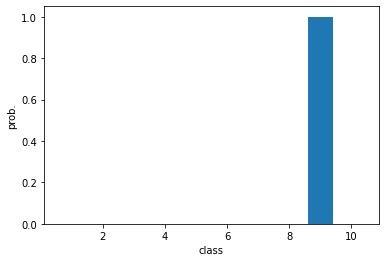

In [15]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [16]:
classes = ['티셔츠','바지','스웨터','드레스','코트','샌달','셔츠','스니커즈','가방',
           '앵클 부츠']

In [17]:
import numpy as np
print(classes[np.argmax(preds)])

가방


- 성능 확인

In [18]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [19]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 4s 11ms/step - loss: 0.2417 - accuracy: 0.9133


[0.24171283841133118, 0.9132999777793884]

In [20]:
model.save('best-cnn-model.h5')